# 

# 这节课会带给你
```
如何用你的垂域数据补充 LLM 的能力
如何构建你的垂域（向量）知识库
搭建一套完整 RAG 系统需要哪些模块

# 二、什么是检索增强的生成模型（RAG）
## 2.1、LLM 固有的局限性
```
LLM 的知识不是实时的
LLM 可能不知道你私有的领域/业务知识
```
## 2.2、检索增强生成
RAG（Retrieval Augmented Generation）顾名思义，通过检索的方法来增强生成模型的能力

## 三、RAG 系统的基本搭建流程
``` txt
搭建过程：

文档加载，并按一定条件切割成片段
将切割的文本片段灌入检索引擎
封装检索接口
构建调用流程：Query -> 检索 -> Prompt -> LLM -> 回复
```

## 3.1、文档的加载与切割

In [1]:
# 安装 pdf 解析库
# !pip install pdfminer.six

In [2]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer

In [3]:
def extract_text_from_pdf(filename, page_numbers=None, min_line_length=1):
    '''从 PDF 文件中（按指定页码）提取文字'''
    paragraphs = []
    buffer = ''
    full_text = ''
    # 提取全部文本
    for i, page_layout in enumerate(extract_pages(filename)):
        # 如果指定了页码范围，跳过范围外的页
        if page_numbers is not None and i not in page_numbers:
            continue
        for element in page_layout:
            if isinstance(element, LTTextContainer):
                full_text += element.get_text() + '\n'
    # 按空行分隔，将文本重新组织成段落
    lines = full_text.split('\n')
    for text in lines:
        if len(text) >= min_line_length:
            buffer += (' '+text) if not text.endswith('-') else text.strip('-')
        elif buffer:
            paragraphs.append(buffer)
            buffer = ''
    if buffer:
        paragraphs.append(buffer)
    return paragraphs

In [4]:
paragraphs = extract_text_from_pdf("llama2.pdf", min_line_length=10)

In [5]:
for para in paragraphs[:3]:
    print(para+"\n")

 Llama 2: Open Foundation and Fine-Tuned Chat Models

 Hugo Touvron∗ Louis Martin† Kevin Stone† Peter Albert Amjad Almahairi Yasmine Babaei Nikolay Bashlykov Soumya Batra Prajjwal Bhargava Shruti Bhosale Dan Bikel Lukas Blecher Cristian Canton Ferrer Moya Chen Guillem Cucurull David Esiobu Jude Fernandes Jeremy Fu Wenyin Fu Brian Fuller Cynthia Gao Vedanuj Goswami Naman Goyal Anthony Hartshorn Saghar Hosseini Rui Hou Hakan Inan Marcin Kardas Viktor Kerkez Madian Khabsa Isabel Kloumann Artem Korenev Punit Singh Koura Marie-Anne Lachaux Thibaut Lavril Jenya Lee Diana Liskovich Yinghai Lu Yuning Mao Xavier Martinet Todor Mihaylov Pushkar Mishra Igor Molybog Yixin Nie Andrew Poulton Jeremy Reizenstein Rashi Rungta Kalyan Saladi Alan Schelten Ruan Silva Eric Michael Smith Ranjan Subramanian Xiaoqing Ellen Tan Binh Tang Ross Taylor Adina Williams Jian Xiang Kuan Puxin Xu Zheng Yan Iliyan Zarov Yuchen Zhang Angela Fan Melanie Kambadur Sharan Narang Aurelien Rodriguez Robert Stojnic Sergey Edu

### 3.2、检索引擎
先看一个最基础的实现
###  安装 ES 客户端
```#!pip install elasticsearch7```
### 安装 NLTK（文本处理方法库
```#!pip install nltk```

In [6]:
from elasticsearch7 import Elasticsearch, helpers
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

import warnings
warnings.simplefilter("ignore")  # 屏蔽 ES 的一些Warnings

# 实验室平台已经内置
nltk.download('punkt')  # 英文切词、词根、切句等方法
nltk.download('stopwords')  # 英文停用词库

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def to_keywords(input_string):
    '''（英文）文本只保留关键字'''
    # 使用正则表达式替换所有非字母数字的字符为空格
    no_symbols = re.sub(r'[^a-zA-Z0-9\s]', ' ', input_string)
    word_tokens = word_tokenize(no_symbols)
    # 加载停用词表
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    # 去停用词，取词根
    filtered_sentence = [ps.stem(w)
                         for w in word_tokens if not w.lower() in stop_words]
    return ' '.join(filtered_sentence)

此处 to_keywords 为针对英文的实现，针对中文的实现请参考 chinese_utils.py

In [8]:
# 1. 创建Elasticsearch连接
es = Elasticsearch(
    hosts=['http://117.50.198.53:9200'],  # 服务地址与端口
    http_auth=("elastic", "FKaB1Jpz0Rlw0l6G"),  # 用户名，密码
)

# 2. 定义索引名称
index_name = "teacher_demo_index_tmp"

# 3. 如果索引已存在，删除它（仅供演示，实际应用时不需要这步）
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

# 4. 创建索引
es.indices.create(index=index_name)

# 5. 灌库指令
actions = [
    {
        "_index": index_name,
        "_source": {
            "keywords": to_keywords(para),
            "text": para
        }
    }
    for para in paragraphs
]

# 6. 文本灌库
helpers.bulk(es, actions)

(125, [])

In [9]:
# 实现关键字检索
def search(query_string, top_n=3):
    # ES 的查询语言
    search_query = {
        "match": {
            "keywords": to_keywords(query_string)
        }
    }
    res = es.search(index=index_name, query=search_query, size=top_n)
    return [hit["_source"]["text"] for hit in res["hits"]["hits"]]

In [10]:
results = search("how many parameters does llama 2 have?", 2)
for r in results:
    print(r+"\n")

### 3.3、LLM 接口封装

In [11]:
from openai import OpenAI
import os
# 加载环境变量
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())  # 读取本地 .env 文件，里面定义了 OPENAI_API_KEY

client = OpenAI()

In [12]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    '''封装 openai 接口'''
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,  # 模型输出的随机性，0 表示随机性最小
    )
    return response.choices[0].message.content

### 3.4、Prompt 模板

In [13]:
def build_prompt(prompt_template, **kwargs):
    '''将 Prompt 模板赋值'''
    prompt = prompt_template
    for k, v in kwargs.items():
        if isinstance(v, str):
            val = v
        elif isinstance(v, list) and all(isinstance(elem, str) for elem in v):
            val = '\n'.join(v)
        else:
            val = str(v)
        prompt = prompt.replace(f"__{k.upper()}__", val)
    return prompt

In [14]:
prompt_template = """
你是一个问答机器人。
你的任务是根据下述给定的已知信息回答用户问题。
确保你的回复完全依据下述已知信息。不要编造答案。
如果下述已知信息不足以回答用户的问题，请直接回复"我无法回答您的问题"。

已知信息:
__INFO__

用户问：
__QUERY__

请用中文回答用户问题。
"""

### 3.5、RAG Pipeline 初探

In [15]:
user_query = "how many parameters does llama 2 have?"

# 1. 检索
search_results = search(user_query, 2)

# 2. 构建 Prompt
prompt = build_prompt(prompt_template, info=search_results, query=user_query)
print("===Prompt===")
print(prompt)

# 3. 调用 LLM
response = get_completion(prompt)

print("===回复===")
print(response)

===Prompt===

你是一个问答机器人。
你的任务是根据下述给定的已知信息回答用户问题。
确保你的回复完全依据下述已知信息。不要编造答案。
如果下述已知信息不足以回答用户的问题，请直接回复"我无法回答您的问题"。

已知信息:
 1. Llama 2, an updated version of Llama 1, trained on a new mix of publicly available data. We also increased the size of the pretraining corpus by 40%, doubled the context length of the model, and adopted grouped-query attention (Ainslie et al., 2023). We are releasing variants of Llama 2 with 7B, 13B, and 70B parameters. We have also trained 34B variants, which we report on in this paper but are not releasing.§
 In this work, we develop and release Llama 2, a collection of pretrained and ﬁne-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters. Our ﬁne-tuned LLMs, called Llama 2-Chat, are optimized for dialogue use cases. Our models outperform open-source chat models on most benchmarks we tested, and based onour human evaluations for helpfulness and safety, may be a suitable substitute for closed source models. We provide a deta

### 3.6、关键字检索的局限性
同一个语义，用词不同，可能导致检索不到有效的结果

In [16]:
user_query="Does llama 2 have a chat version?"
# user_query = "Does llama 2 have a conversational variant?"

search_results = search(user_query, 2)

for res in search_results:
    print(res+"\n")

 2. Llama 2-Chat, a ﬁne-tuned version of Llama 2 that is optimized for dialogue use cases. We release

 Figure 4: Training of Llama 2-Chat: This process begins with the pretraining of Llama 2 using publicly available online sources. Following this, we create an initial version of Llama 2-Chat through the application of supervised ﬁne-tuning. Subsequently, the model is iteratively reﬁned using Reinforcement Learning with Human Feedback (RLHF) methodologies, speciﬁcally through rejection sampling and Proximal Policy Optimization (PPO). Throughout the RLHF stage, the accumulation of iterative reward modeling data in parallel with model enhancements is crucial to ensure the reward models remain within distribution.



# 四、向量检索
## 4.1、文本向量（Text Embeddings）
```
将文本转成一组浮点数：每个下标 ，对应一个维度
整个数组对应一个 n-维空间的一个点，即文本向量又叫 Embeddings
向量之间可以计算距离，距离远近对应语义相似度大小
```

### 4.1.1、文本向量是怎么得到的（选）
构建相关（正立）与不相关（负例）的句子对儿样本
训练双塔式模型，让正例间的距离小，负例间的距离大

## 

In [17]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [18]:
def cos_sim(a, b):
    '''余弦距离 -- 越大越相似'''
    return dot(a, b)/(norm(a)*norm(b))


def l2(a, b):
    '''欧氏距离 -- 越小越相似'''
    x = np.asarray(a)-np.asarray(b)
    return norm(x)

In [19]:
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv
import json

_ = load_dotenv(find_dotenv())

client = OpenAI()

In [20]:
def get_embeddings(texts, model="text-embedding-ada-002", dimensions=None):
    '''封装 OpenAI 的 Embedding 模型接口'''
    if model == "text-embedding-ada-002":
        dimensions = None
    if dimensions:
        data = client.embeddings.create(
            input=texts, model=model, dimensions=dimensions).data
    else:
        data = client.embeddings.create(input=texts, model=model).data
    return [x.embedding for x in data]

In [21]:
test_query = ["测试文本"]
vec = get_embeddings(test_query)[0]
print(f"Total dimension: {len(vec)}")
print(f"First 10 elements: {vec[:10]}")

Total dimension: 1536
First 10 elements: [-0.007345176301896572, -0.006184070836752653, -0.0106210233643651, 0.0014231734676286578, -0.010679260827600956, 0.02924967184662819, -0.01981523260474205, 0.005386948119848967, -0.016888810321688652, -0.012040556408464909]


In [22]:
# query = "国际争端"

# 且能支持跨语言
query = "global conflicts"

documents = [
    "联合国就苏丹达尔富尔地区大规模暴力事件发出警告",
    "土耳其、芬兰、瑞典与北约代表将继续就瑞典“入约”问题进行谈判",
    "日本岐阜市陆上自卫队射击场内发生枪击事件 3人受伤",
    "国家游泳中心（水立方）：恢复游泳、嬉水乐园等水上项目运营",
    "我国首次在空间站开展舱外辐射生物学暴露实验",
]

query_vec = get_embeddings([query])[0]
doc_vecs = get_embeddings(documents)

print("Query与自己的余弦距离: {:.2f}".format(cos_sim(query_vec, query_vec)))
print("Query与Documents的余弦距离:")
for vec in doc_vecs:
    print(cos_sim(query_vec, vec))

print()

print("Query与自己的欧氏距离: {:.2f}".format(l2(query_vec, query_vec)))
print("Query与Documents的欧氏距离:")
for vec in doc_vecs:
    print(l2(query_vec, vec))

Query与自己的余弦距离: 1.00
Query与Documents的余弦距离:
0.7622376995981269
0.7564484035029618
0.7426558372998221
0.7077987135264395
0.7254230492369407

Query与自己的欧氏距离: 0.00
Query与Documents的欧氏距离:
0.6895829747071625
0.697927847429074
0.7174178392255148
0.7644623330084925
0.7410492267209755


## 4.3、向量数据库
向量数据库，是专门为向量检索设计的中间件

In [23]:
# !pip install chromadb
# __import__('pysqlite3')
# import sys

# sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [24]:
# 为了演示方便，我们只取两页（第一章）
paragraphs = extract_text_from_pdf(
    "llama2.pdf",
    page_numbers=[2, 3],
    min_line_length=10
)
paragraphs

[' Figure 1: Helpfulness human evaluation results for Llama 2-Chat compared to other open-source and closed-source models. Human raters compared model generations on ~4k prompts consisting of both single and multi-turn prompts. The 95% conﬁdence intervals for this evaluation are between 1% and 2%. More details in Section 3.4.2. While reviewing these results, it is important to note that human evaluations can be noisy due to limitations of the prompt set, subjectivity of the review guidelines, subjectivity of individual raters, and the inherent diﬃculty of comparing generations.',
 ' Figure 2: Win-rate % for helpfulness andsafety between commercial-licensed baselines and Llama 2-Chat, according to GPT 4. To complement the human evaluation, we used a more capable model, not subject to our own guidance. Green area indicates our model is better according to GPT-4. To remove ties, we used win/(win + loss). The orders in which the model responses are presented to GPT-4 are randomly swapped t

In [25]:
import chromadb
from chromadb.config import Settings


class MyVectorDBConnector:
    def __init__(self, collection_name, embedding_fn):
        chroma_client = chromadb.Client(Settings(allow_reset=True))

        # 为了演示，实际不需要每次 reset()
        chroma_client.reset()

        # 创建一个 collection
        self.collection = chroma_client.get_or_create_collection(
            name=collection_name)
        self.embedding_fn = embedding_fn

    def add_documents(self, documents):
        '''向 collection 中添加文档与向量'''
        self.collection.add(
            embeddings=self.embedding_fn(documents),  # 每个文档的向量
            documents=documents,  # 文档的原文
            ids=[f"id{i}" for i in range(len(documents))]  # 每个文档的 id
        )

    def search(self, query, top_n):
        '''检索向量数据库'''
        results = self.collection.query(
            query_embeddings=self.embedding_fn([query]),
            n_results=top_n
        )
        return results

In [26]:
# 创建一个向量数据库对象
vector_db = MyVectorDBConnector("demo", get_embeddings)
# 向向量数据库中添加文档
vector_db.add_documents(paragraphs)

In [27]:
user_query = "Llama 2有多少参数"
results = vector_db.search(user_query, 2)

In [28]:
for para in results['documents'][0]:
    print(para+"\n")

 1. Llama 2, an updated version of Llama 1, trained on a new mix of publicly available data. We also increased the size of the pretraining corpus by 40%, doubled the context length of the model, and adopted grouped-query attention (Ainslie et al., 2023). We are releasing variants of Llama 2 with 7B, 13B, and 70B parameters. We have also trained 34B variants, which we report on in this paper but are not releasing.§

 In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models. They also appear to be on par with some of the closed-source models, at least on the human evaluations we performed (see Figures 1 and 3). We have taken measures to increase the safety of these models, using safety-speciﬁc data annotation and tuning, as well as conducting red-teaming and emp

```
澄清几个关键概念：
- 向量数据库的意义是快速的检索；
- 向量数据库本身不生成向量，向量是由 Embedding 模型产生的；
- 向量数据库与传统的关系型数据库是互补的，不是替代关系，在实际应用中根据实际需求经常同时使用。

### 4.3.1、向量数据库服务
Server 端

chroma run --path /db_path

Client 端

import chromadb
chroma_client = chromadb.HttpClient(host='localhost', port=800

### 4.3.2、主流向量数据库功能对比

FAISS: Meta 开源的向量检索引擎 https://github.com/facebookresearch/faiss

Pinecone: 商用向量数据库，只有云服务 https://www.pinecone.io/

Milvus: 开源向量数据库，同时有云服务 https://milvus.io/

Weaviate: 开源向量数据库，同时有云服务 https://weaviate.io/

Qdrant: 开源向量数据库，同时有云服务 https://qdrant.tech/

PGVector: Postgres 的开源向量检索引擎 https://github.com/pgvector/pgvector

RediSearch: Redis 的开源向量检索引擎 https://github.com/RediSearch/RediSearch

ElasticSearch 也支持向量检索 https://www.elastic.co/enterprise-search/vector-search


## 4.4、基于向量检索的 RAG

In [29]:
class RAG_Bot:
    def __init__(self, vector_db, llm_api, n_results=2):
        self.vector_db = vector_db
        self.llm_api = llm_api
        self.n_results = n_results

    def chat(self, user_query):
        # 1. 检索
        search_results = self.vector_db.search(user_query, self.n_results)

        # 2. 构建 Prompt
        prompt = build_prompt(
            prompt_template, context=search_results['documents'][0], query=user_query)

        # 3. 调用 LLM
        response = self.llm_api(prompt)
        return response

In [30]:
# 创建一个RAG机器人
bot = RAG_Bot(
    vector_db,
    llm_api=get_completion
)

user_query = "llama 2有多少参数?"

response = bot.chat(user_query)

print(response)

我无法回答您的问题


## 4.5、如果想要换个国产模型

In [31]:
import json
import requests
import os

# 通过鉴权接口获取 access token


def get_access_token():
    """
    使用 AK，SK 生成鉴权签名（Access Token）
    :return: access_token，或是None(如果错误)
    """
    url = "https://aip.baidubce.com/oauth/2.0/token"
    params = {
        "grant_type": "client_credentials",
        "client_id": os.getenv('ERNIE_CLIENT_ID'),
        "client_secret": os.getenv('ERNIE_CLIENT_SECRET')
    }

    return str(requests.post(url, params=params).json().get("access_token"))

# 调用文心千帆 调用 BGE Embedding 接口


def get_embeddings_bge(prompts):
    url = "https://aip.baidubce.com/rpc/2.0/ai_custom/v1/wenxinworkshop/embeddings/bge_large_en?access_token=" + get_access_token()
    payload = json.dumps({
        "input": prompts
    })
    headers = {'Content-Type': 'application/json'}

    response = requests.request(
        "POST", url, headers=headers, data=payload).json()
    data = response["data"]
    return [x["embedding"] for x in data]


# 调用文心4.0对话接口
def get_completion_ernie(prompt):

    url = "https://aip.baidubce.com/rpc/2.0/ai_custom/v1/wenxinworkshop/chat/completions_pro?access_token=" + get_access_token()
    payload = json.dumps({
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ]
    })

    headers = {'Content-Type': 'application/json'}

    response = requests.request(
        "POST", url, headers=headers, data=payload).json()

    return response["result"]

In [32]:
# 创建一个向量数据库对象
new_vector_db = MyVectorDBConnector(
    "demo_ernie",
    embedding_fn=get_embeddings_bge
)
# 向向量数据库中添加文档
new_vector_db.add_documents(paragraphs)

# 创建一个RAG机器人
new_bot = RAG_Bot(
    new_vector_db,
    llm_api=get_completion_ernie
)

KeyError: 'data'

In [ ]:
user_query = "how many parameters does llama 2 have?"

response = new_bot.chat(user_query)

print(response)

## 4.6、OpenAI 新发布的两个 Embedding 模型
2024 年 1 月 25 日，OpenAI 新发布了两个 Embedding 模型

text-embedding-3-large
text-embedding-3-small
其最大特点是，支持自定义的缩短向量维度，从而在几乎不影响最终效果的情况下降低向量检索与相似度计算的复杂度。

通俗的说：越大越准、越小越快。

In [ ]:
model = "text-embedding-3-large"
dimensions = 128

# query = "国际争端"

# 且能支持跨语言
query = "global conflicts"

documents = [
    "联合国就苏丹达尔富尔地区大规模暴力事件发出警告",
    "土耳其、芬兰、瑞典与北约代表将继续就瑞典“入约”问题进行谈判",
    "日本岐阜市陆上自卫队射击场内发生枪击事件 3人受伤",
    "国家游泳中心（水立方）：恢复游泳、嬉水乐园等水上项目运营",
    "我国首次在空间站开展舱外辐射生物学暴露实验",
]

query_vec = get_embeddings([query], model=model, dimensions=dimensions)[0]
doc_vecs = get_embeddings(documents, model=model, dimensions=dimensions)

print("向量维度: {}".format(len(query_vec)))

print()

print("Query与Documents的余弦距离:")
for vec in doc_vecs:
    print(cos_sim(query_vec, vec))

print()

print("Query与Documents的欧氏距离:")
for vec in doc_vecs:
    print(l2(query_vec, vec))

向量维度: 128

Query与Documents的余弦距离:
0.33398035655745417
0.35305810019375855
0.3139780154086699
0.21373493457996703
0.12878899474455177

Query与Documents的欧氏距离:
1.1541400966944355
1.1374901586221358
1.1713428077131849
1.2540056518268035
1.3200083334660306


# 五、实战 RAG 系统的进阶知识
## 5.1、文本分割的粒度
```
缺陷

粒度太大可能导致检索不精准，粒度太小可能导致信息不全面
问题的答案可能跨越两个片段

In [ ]:
# 创建一个向量数据库对象
vector_db = MyVectorDBConnector("demo_text_split", get_embeddings)
# 向向量数据库中添加文档
vector_db.add_documents(paragraphs)

# 创建一个RAG机器人
bot = RAG_Bot(
    vector_db,
    llm_api=get_completion
)

In [ ]:
# user_query = "llama 2有商用许可协议吗"
user_query="llama 2 chat有多少参数"
search_results = vector_db.search(user_query, 2)

for doc in search_results['documents'][0]:
    print(doc+"\n")

print("====回复====")
bot.chat(user_query)

 In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models. They also appear to be on par with some of the closed-source models, at least on the human evaluations we performed (see Figures 1 and 3). We have taken measures to increase the safety of these models, using safety-speciﬁc data annotation and tuning, as well as conducting red-teaming and employing iterative evaluations. Additionally, this paper contributes a thorough description of our ﬁne-tuning methodology and approach to improving LLM safety. We hope that this openness will enable the community to reproduce ﬁne-tuned LLMs and continue to improve the safety of those models, paving the way for more responsible development of LLMs. We also share novel observations we made during the development of Llam

'我无法回答您的问题。'

In [ ]:
for p in paragraphs:
    print(p+"\n")

 Figure 1: Helpfulness human evaluation results for Llama 2-Chat compared to other open-source and closed-source models. Human raters compared model generations on ~4k prompts consisting of both single and multi-turn prompts. The 95% conﬁdence intervals for this evaluation are between 1% and 2%. More details in Section 3.4.2. While reviewing these results, it is important to note that human evaluations can be noisy due to limitations of the prompt set, subjectivity of the review guidelines, subjectivity of individual raters, and the inherent diﬃculty of comparing generations.

 Figure 2: Win-rate % for helpfulness andsafety between commercial-licensed baselines and Llama 2-Chat, according to GPT 4. To complement the human evaluation, we used a more capable model, not subject to our own guidance. Green area indicates our model is better according to GPT-4. To remove ties, we used win/(win + loss). The orders in which the model responses are presented to GPT-4 are randomly swapped to all

In [ ]:
from nltk.tokenize import sent_tokenize
import json


def split_text(paragraphs, chunk_size=300, overlap_size=100):
    '''按指定 chunk_size 和 overlap_size 交叠割文本'''
    sentences = [s.strip() for p in paragraphs for s in sent_tokenize(p)]
    chunks = []
    i = 0
    while i < len(sentences):
        chunk = sentences[i]
        overlap = ''
        prev_len = 0
        prev = i - 1
        # 向前计算重叠部分
        while prev >= 0 and len(sentences[prev])+len(overlap) <= overlap_size:
            overlap = sentences[prev] + ' ' + overlap
            prev -= 1
        chunk = overlap+chunk
        next = i + 1
        # 向后计算当前chunk
        while next < len(sentences) and len(sentences[next])+len(chunk) <= chunk_size:
            chunk = chunk + ' ' + sentences[next]
            next += 1
        chunks.append(chunk)
        i = next
    return chunks

In [ ]:
chunks = split_text(paragraphs, 300, 100)

In [ ]:
# 创建一个向量数据库对象
vector_db = MyVectorDBConnector("demo_text_split", get_embeddings)
# 向向量数据库中添加文档
vector_db.add_documents(chunks)
# 创建一个RAG机器人
bot = RAG_Bot(
    vector_db,
    llm_api=get_completion
)

In [ ]:
# user_query = "llama 2有商用许可协议吗"
user_query="llama 2 chat有多少参数"

search_results = vector_db.search(user_query, 2)
for doc in search_results['documents'][0]:
    print(doc+"\n")

response = bot.chat(user_query)
print("====回复====")
print(response)

2. Llama 2-Chat, a ﬁne-tuned version of Llama 2 that is optimized for dialogue use cases. We release variants of this model with 7B, 13B, and 70B parameters as well. We believe that the open release of LLMs, when done safely, will be a net beneﬁt to society.

In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models.

====回复====
我无法回答您的问题。


## 5.2、检索后排序（选）
问题: 有时，最合适的答案不一定排在检索的最前面

方案:

检索时过招回一部分文本
通过一个排序模型对 query 和 document 重新打分排序

In [ ]:
user_query = "how safe is llama 2"
search_results = vector_db.search(user_query, 5)

for doc in search_results['documents'][0]:
    print(doc+"\n")

response = bot.chat(user_query)
print("====回复====")
print(response)

InvalidCollectionException: Collection 2f4a4ce2-e24e-4f68-89c6-0852e6daed68 does not exist.

In [ ]:
from sentence_transformers import CrossEncoder

# model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512) # 英文，模型较小
model = CrossEncoder('BAAI/bge-reranker-large', max_length=512) # 多语言，国产，模型较大

ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
user_query = "how safe is llama 2"
# user_query = "llama 2安全性如何"
scores = model.predict([(user_query, doc)
                       for doc in search_results['documents'][0]])
# 按得分排序
sorted_list = sorted(
    zip(scores, search_results['documents'][0]), key=lambda x: x[0], reverse=True)
for score, doc in sorted_list:
    print(f"{score}\t{doc}\n")

NameError: name 'model' is not defined

## 5.3、混合检索（Hybrid Search）（选）

在实际生产中，传统的关键字检索（稀疏表示）与向量检索（稠密表示）各有优劣。

举个具体例子，比如文档中包含很长的专有名词，关键字检索往往更精准而向量检索容易引入概念混淆。

In [33]:
# 背景说明：在医学中“小细胞肺癌”和“非小细胞肺癌”是两种不同的癌症

query = "非小细胞肺癌的患者"

documents = [
    "玛丽患有肺癌，癌细胞已转移",
    "刘某肺癌I期",
    "张某经诊断为非小细胞肺癌III期",
    "小细胞肺癌是肺癌的一种"
]

query_vec = get_embeddings([query])[0]
doc_vecs = get_embeddings(documents)

print("Cosine distance:")
for vec in doc_vecs:
    print(cos_sim(query_vec, vec))

Cosine distance:
0.8913007581038243
0.8897648918974229
0.9040803406710733
0.9132102982983261


### 5.3.1、我们手写个简单的例子

1. 基于关键字检索的排序

In [1]:
import time


class MyEsConnector:
    def __init__(self, es_client, index_name, keyword_fn):
        self.es_client = es_client
        self.index_name = index_name
        self.keyword_fn = keyword_fn

    def add_documents(self, documents):
        '''文档灌库'''
        if self.es_client.indices.exists(index=self.index_name):
            self.es_client.indices.delete(index=self.index_name)
        self.es_client.indices.create(index=self.index_name)
        actions = [
            {
                "_index": self.index_name,
                "_source": {
                    "keywords": self.keyword_fn(doc),
                    "text": doc,
                    "id": f"doc_{i}"
                }
            }
            for i, doc in enumerate(documents)
        ]
        helpers.bulk(self.es_client, actions)
        time.sleep(1)

    def search(self, query_string, top_n=3):
        '''检索'''
        search_query = {
            "match": {
                "keywords": self.keyword_fn(query_string)
            }
        }
        res = self.es_client.search(
            index=self.index_name, query=search_query, size=top_n)
        return {
            hit["_source"]["id"]: {
                "text": hit["_source"]["text"],
                "rank": i,
            }
            for i, hit in enumerate(res["hits"]["hits"])
        }

In [2]:
from chinese_utils import to_keywords  # 使用中文的关键字提取函数

es = Elasticsearch(
    hosts=['http://39.106.141.169:9200'],  # 服务地址与端口
    http_auth=("elastic", "FKaB1Jpz0Rlw0l6G"),  # 用户名，密码
)


# 创建 ES 连接器
es_connector = MyEsConnector(es, "demo_es_rrf", to_keywords)

# 文档灌库
es_connector.add_documents(documents)

# 关键字检索
keyword_search_results = es_connector.search(query, 3)

print(json.dumps(keyword_search_results, indent=4, ensure_ascii=False))

ModuleNotFoundError: No module named 'chinese_utils'

2. 基于向量检索的排序

In [3]:
# 创建向量数据库连接器
vecdb_connector = MyVectorDBConnector("demo_vec_rrf", get_embeddings)

# 文档灌库
vecdb_connector.add_documents(documents)

# 向量检索
vector_search_results = {
    "doc_"+str(documents.index(doc)): {
        "text": doc,
        "rank": i
    }
    for i, doc in enumerate(
        vecdb_connector.search(query, 3)["documents"][0]
    )
}  # 把结果转成跟上面关键字检索结果一样的格式

print(json.dumps(vector_search_results, indent=4, ensure_ascii=False))

NameError: name 'MyVectorDBConnector' is not defined

3. 基于 RRF 的融合排序

In [4]:
def rrf(ranks, k=1):
    ret = {}
    # 遍历每次的排序结果
    for rank in ranks:
        # 遍历排序中每个元素
        for id, val in rank.items():
            if id not in ret:
                ret[id] = {"score": 0, "text": val["text"]}
            # 计算 RRF 得分
            ret[id]["score"] += 1.0/(k+val["rank"])
    # 按 RRF 得分排序，并返回
    return dict(sorted(ret.items(), key=lambda item: item[1]["score"], reverse=True))

In [5]:
import json

# 融合两次检索的排序结果
reranked = rrf([keyword_search_results, vector_search_results])

print(json.dumps(reranked, indent=4, ensure_ascii=False))

NameError: name 'keyword_search_results' is not defined

## 六、向量模型的本地加载与运行

```
划重点：
不是每个 Embedding 模型都对余弦距离和欧氏距离同时有效
哪种相似度计算有效要阅读模型的说明（通常都支持余弦距离计算）

In [ ]:
from sentence_transformers import SentenceTransformer

model_name = 'BAAI/bge-large-zh-v1.5' #中文
# model_name = 'moka-ai/m3e-base'  # 中英双语，但效果一般
# model_name = 'BAAI/bge-m3' # 多语言，但效果一般

model = SentenceTransformer(model_name)

query = "国际争端"
# query = "global conflicts"

documents = [
    "联合国就苏丹达尔富尔地区大规模暴力事件发出警告",
    "土耳其、芬兰、瑞典与北约代表将继续就瑞典“入约”问题进行谈判",
    "日本岐阜市陆上自卫队射击场内发生枪击事件 3人受伤",
    "国家游泳中心（水立方）：恢复游泳、嬉水乐园等水上项目运营",
    "我国首次在空间站开展舱外辐射生物学暴露实验",
]

query_vec = model.encode(query)

doc_vecs = [
    model.encode(doc)
    for doc in documents
]

print("Cosine distance:")  # 越大越相似
# print(cos_sim(query_vec, query_vec))
for vec in doc_vecs:
    print(cos_sim(query_vec, vec))

# 七、PDF 文档中的表格怎么处理（选）

1. 将每页 PDF 转成图片

In [7]:
import os
import fitz
from PIL import Image

def pdf2images(pdf_file):
    '''将 PDF 每页转成一个 PNG 图像'''
    # 保存路径为原 PDF 文件名（不含扩展名）
    output_directory_path, _ = os.path.splitext(pdf_file)
    
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    
    # 加载 PDF 文件
    pdf_document = fitz.open(pdf_file)
    
    # 每页转一张图
    for page_number in range(pdf_document.page_count):
        # 取一页
        page = pdf_document[page_number]
    
        # 转图像
        pix = page.get_pixmap()
    
        # 从位图创建 PNG 对象
        image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
        # 保存 PNG 文件
        image.save(f"./{output_directory_path}/page_{page_number + 1}.png")
    
    # 关闭 PDF 文件
    pdf_document.close()

In [9]:
from PIL import Image
import os
import matplotlib.pyplot as plt

def show_images(dir_path):
    '''显示目录下的 PNG 图像'''
    for file in os.listdir(dir_path):
        if file.endswith('.png'):
            # 打开图像
            img = Image.open(os.path.join(dir_path, file)) 

            # 显示图像
            plt.imshow(img)
            plt.axis('off')  # 不显示坐标轴
            plt.show()

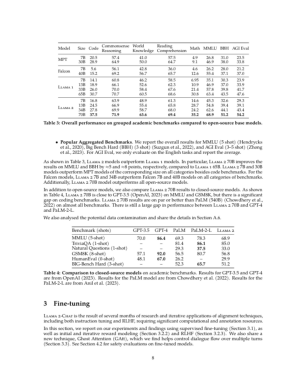

In [10]:
pdf2images("llama2_page8.pdf")
show_images("llama2_page8")

2. 识别文档（图片）中的表格

In [11]:
class MaxResize(object):
    '''缩放图像'''
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )

        return resized_image


In [12]:
import torchvision.transforms as transforms

# 图像预处理
detection_transform = transforms.Compose(
    [
        MaxResize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


ModuleNotFoundError: No module named 'torchvision'

In [13]:
from transformers import AutoModelForObjectDetection

# 加载 TableTransformer 模型
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection"
)

ModuleNotFoundError: No module named 'transformers'

In [14]:
# 识别后的坐标换算与后处理

def box_cxcywh_to_xyxy(x):
    '''坐标转换'''
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    '''区域缩放'''
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor(
        [width, height, width, height], dtype=torch.float32
    )
    return boxes


def outputs_to_objects(outputs, img_size, id2label):
    '''从模型输出中取定位框坐标'''
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [
        elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)
    ]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append(
                {
                    "label": class_label,
                    "score": float(score),
                    "bbox": [float(elem) for elem in bbox],
                }
            )

    return objects

In [15]:
import torch

# 识别表格，并将表格部分单独存为图像文件

def detect_and_crop_save_table(file_path):
    # 加载图像（PDF页）    
    image = Image.open(file_path)

    filename, _ = os.path.splitext(os.path.basename(file_path))

    # 输出路径
    cropped_table_directory = os.path.join(os.path.dirname(file_path), "table_images")

    if not os.path.exists(cropped_table_directory):
        os.makedirs(cropped_table_directory)

    # 预处理
    pixel_values = detection_transform(image).unsqueeze(0)

    # 识别表格
    with torch.no_grad():
        outputs = model(pixel_values)

    # 后处理，得到表格子区域
    id2label = model.config.id2label
    id2label[len(model.config.id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    print(f"number of tables detected {len(detected_tables)}")

    for idx in range(len(detected_tables)):
        # 将识别从的表格区域单独存为图像
        cropped_table = image.crop(detected_tables[idx]["bbox"])
        cropped_table.save(os.path.join(cropped_table_directory,f"{filename}_{idx}.png"))

ModuleNotFoundError: No module named 'torch'

In [16]:
detect_and_crop_save_table("llama2_page8/page_1.png")
show_images("llama2_page8/table_images")

NameError: name 'detect_and_crop_save_table' is not defined

3. 基于 GPT-4 Vision API 做表格问答

In [17]:
import base64
from openai import OpenAI

client = OpenAI()

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def image_qa(query, image_path):
    base64_image = encode_image(image_path)
    response = client.chat.completions.create(
        model="gpt-4-turbo",
        temperature=0,
        seed=42,
        messages=[{
            "role": "user",
              "content": [
                  {"type": "text", "text": query},
                  {
                      "type": "image_url",
                      "image_url": {
                          "url": f"data:image/jpeg;base64,{base64_image}",
                      },
                  },
              ],
        }],
    )

    return response.choices[0].message.content

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [18]:
response = image_qa("哪个模型在AGI Eval数据集上表现最好。得分多少","llama2_page8/table_images/page_1_0.png")
print(response)

NameError: name 'image_qa' is not defined

4. 用 GPT-4 Vision 生成表格（图像）描述，并向量化用于检索

In [19]:
import chromadb
from chromadb.config import Settings


class NewVectorDBConnector:
    def __init__(self, collection_name, embedding_fn):
        chroma_client = chromadb.Client(Settings(allow_reset=True))

        # 为了演示，实际不需要每次 reset()
        chroma_client.reset()

        # 创建一个 collection
        self.collection = chroma_client.get_or_create_collection(
            name=collection_name)
        self.embedding_fn = embedding_fn

    def add_documents(self, documents):
        '''向 collection 中添加文档与向量'''
        self.collection.add(
            embeddings=self.embedding_fn(documents),  # 每个文档的向量
            documents=documents,  # 文档的原文
            ids=[f"id{i}" for i in range(len(documents))]  # 每个文档的 id
        )

    def add_images(self, image_paths):
        '''向 collection 中添加图像'''
        documents = [
            image_qa("请简要描述图片中的信息",image)
            for image in image_paths
        ]
        self.collection.add(
            embeddings=self.embedding_fn(documents),  # 每个文档的向量
            documents=documents,  # 文档的原文
            ids=[f"id{i}" for i in range(len(documents))],  # 每个文档的 id
            metadatas=[{"image": image} for image in image_paths] # 用 metadata 标记源图像路径
        )

    def search(self, query, top_n):
        '''检索向量数据库'''
        results = self.collection.query(
            query_embeddings=self.embedding_fn([query]),
            n_results=top_n
        )
        return results

In [20]:
images = []
dir_path = "llama2_page8/table_images"
for file in os.listdir(dir_path):
    if file.endswith('.png'):
        # 打开图像
        images.append(os.path.join(dir_path, file))

new_db_connector = NewVectorDBConnector("table_demo",get_embeddings)
new_db_connector.add_images(images)

FileNotFoundError: [Errno 2] No such file or directory: 'llama2_page8/table_images'

In [21]:
query  = "哪个模型在AGI Eval数据集上表现最好。得分多少"

results = new_db_connector.search(query, 1)
metadata = results["metadatas"][0]
print("====检索结果====")
print(metadata)
print("====回复====")
response = image_qa(query,metadata[0]["image"])
print(response)

NameError: name 'new_db_connector' is not defined

### 一些面向 RAG 的文档解析辅助工具

- [PyMuPDF](https://pymupdf.readthedocs.io/en/latest/): PDF 文件处理基础库，带有基于规则的表格与图像抽取（不准）
- [RAGFlow](https://github.com/infiniflow/ragflow): 一款基于深度文档理解构建的开源 RAG 引擎，支持多种文档格式
- [Unstructured.io](https://unstructured.io/): 一个开源+SaaS形式的文档解析库，支持多种文档格式

在工程上，PDF 解析本身是个复杂且琐碎的工作。以上工具都不完美，建议在自己实际场景测试后选择使用。

## 总结

### RAG 的流程

- 离线步骤：
  1. 文档加载
  2. 文档切分
  3. 向量化
  4. 灌入向量数据库
- 在线步骤：
  1. 获得用户问题
  2. 用户问题向量化
  3. 检索向量数据库
  4. 将检索结果和用户问题填入 Prompt 模版
  5. 用最终获得的 Prompt 调用 LLM
  6. 由 LLM 生成回复

### 我用了一个开源的 RAG，不好使怎么办？

1. 检查预处理效果：文档加载是否正确，切割的是否合理
2. 测试检索效果：问题检索回来的文本片段是否包含答案
3. 测试大模型能力：给定问题和包含答案文本片段的前提下，大模型能不能正确回答问题
